In [1]:
import pandas as pd
from openpyxl import Workbook
import openpyxl
import argparse, os

In [2]:
os.chdir("/Users/codymartin/Documents/CPT/N4/plate_reader/")
os.getcwd()

'/Users/codymartin/Documents/CPT/N4/plate_reader'

In [3]:
class WellPlate:
    def __init__(self, data, setup, points_per_well=4, outdir="output"):
        self.file = data
        self.outdir = outdir
        '''
        Read in excel workbook witn openpyxl
        '''
        self.workbook = openpyxl.load_workbook(self.file, read_only=True)
        
        '''
        Extract information from the plate setup file
        '''
        self.plate_setup = pd.read_csv(setup, dtype={i+1 : str for i in range(12)}).set_index("row")
        
        '''
        Keep track of points per well, or measurements taken per well.
        '''
        self.ppw = points_per_well
    
    def create96Wellplate(self):
        '''
        Make all possible row/column com binations in a standard 96-well plate
        '''
        self.row_letters = list(self.plate_setup.index)
        self.col_numbers = list(self.plate_setup.columns)
        self.all_wells = set((row+col) for row in self.row_letters for col in self.col_numbers)
    
    def enumerateSamples(self):
        '''
        First create a list of all values in the plate_setup table. This will include all 
        replicates and any missing values.
        '''
        self.samples = [
            self.plate_setup.iloc[row, col] 
            for row in range(8) 
            for col in range(12)
        ]
        
        '''
        Removing null values, ie empty wells
        '''
        self.samples = [sample for sample in self.samples if not pd.isnull(sample)]
        
        '''
        Converting the list to a set will only return unique values, meaning that all
        samples are in this object only once.
        '''
        self.samples = list(set(self.samples))
    
    def createReplicatesList(self):
        def findReplicates(sample):
            '''
            Get bool dataframe with True at positions where the given value exists
            '''
            hits = self.plate_setup.isin([sample])

            '''
            Convert that result to column names
            '''
            hits_series = hits.any()
            cols = list(hits_series[hits_series == True].index)

            '''
            Get row names 
            '''
            rows = [list(hits[col][hits[col] == True].index) for col in cols]
            rows = [j for i in rows for j in i] # needed to flatten a 2d list

            '''
            For a given sample, concatenate the row/col coordinate into a single list
            '''
            positions = [row+col for row,col in zip(*[rows,cols])]

            return positions
        
        self.replicates = {
            sample : findReplicates(sample) 
            for sample in self.samples
        }
        
        self.cells = sum(list(self.replicates.values()), [])
    
    def setActiveSheet(self, active_sheet=0):
        '''
        Excel worksheets can have different sheets. Here we need to set the active
        sheet to the sheet with the raw data.
        '''
        self.workbook.active = active_sheet
        self.sheet = self.workbook.active
    
    def setStartExcelCell(self):
        '''
        First, need to find the first cell in the excel spreadsheet that actually
        could contain data. In the standard output of the tecan iControl software,
        there are ~59 rows of metadata that need to be ignored.
        '''
        def findFirstDatatable():
            self.found_first_datatable = False
            for row in self.sheet.iter_rows():
                for cell in row:
                    if cell.value in self.all_wells:
                        self.start_cell = cell.coordinate
                        self.found_first_datatable = True
                if self.found_first_datatable:
                    break
        
        findFirstDatatable()
        
        def splitCellCoordinates():
            '''
            Excel labels columns as letters from A...Z and rows as numbers 
            (unfortunately, opposite from the 96-well plate labeling). We need to
            split the start_cell coordinate (usually "A60") into two separate 
            lists. 
            '''
            self.xl_col_letters = [char for char in self.start_cell if char.isalpha()]
            self.xl_row_num = [char for char in self.start_cell if not char.isalpha()]

            self.start_cell_split = [
                ''.join(self.xl_col_letters), ''.join(self.xl_row_num)
            ]
        
        splitCellCoordinates()
    
        self.start_row = int(self.start_cell_split[1])
        '''
        The end row is the end row for a particular well, ie the end row of that 
        data table. It should be equal exactly 4 + points_per_well away from the
        start_row, where points_per_well is the number of measurements taken per 
        well. The +4 is for the temp, time, mean, and stdev rows
        '''
        self.end_row = self.start_row + 4 + self.ppw 
    
    def getNumTimepoints(self):
        '''
        The start_row is where the first well was scanned, so it has the correct number
        of columns based on the label and timepoints.
        
        This code iterates through all the cells in the start_row and checks if the cell
        isn't empty before it adds it to the number of timepoints.
        
        Then it subtracts 1 for the data labels column to report the true number
        of timepoints.
        '''
        self.num_timepoints = sum([
            True if cell.value != None
            else False
            for cell in self.sheet[self.start_row]
        ]) - 1
    
    def getAllDataTables(self):
        '''
        Make a list of all cell values grouped into tuples per row. 
        '''
        self.data = list(self.sheet.values)
        
        def getWellTable(start_row, end_row):
            '''
            Get column names for each data table. This function will exit if the 
            well name is not in the list of well coordinates that contain samples.
            '''
            cols = [
                cell.value 
                for row in self.sheet.iter_rows(min_row=start_row,max_row=start_row)
                for cell in row
            ]
            
            if cols[0] not in self.cells:
                return None
            else:
                '''
                Subset the cell values to only contain the data between the start_row and 
                end_row variables. This will only grab the data tables for each well.
                '''
                data = [self.data[row] for row in range(start_row,end_row)]

                df = pd.DataFrame(data, columns=cols)

                '''
                Drop any columns containing NA values. This usually happens when you plan the
                kinetic cycle to go for x amount of time, but stop it early.
                '''
                df.dropna(inplace=True, axis=1)
                
                '''
                Set name to be the sample name.
                '''
                locator = [
                    True if cols[0] in s
                    else False
                    for s in self.replicates.values()
                ]
                idx = locator.index(True)
                df.name = list(self.replicates.keys())[idx]
                
                
                '''
                The first column only has metadata, so set that to the dataframe index.
                '''
                df.set_index(cols[0], inplace=True)

                time_min = [t/60 for t in df.iloc[0,:]]
                time_hr = [round(t/3600, 3) for t in df.iloc[0,:]]

                df.loc["Time [m]"] = time_min
                df.loc["Time [h]"] = time_hr
                df.sort_index(ascending = False, inplace=True)
            
            return df
        '''
        This will only return the data tables of wells with data. More specifically, it 
        will only return tables whose sample name is in the plate_setup file. This means 
        that you can have the code will ignore any blank cells, even if the plate reader 
        scanned those. Suppose that you had two separate experiments on the same plate. 
        You can keep the analysis separate by changing your plate_setup file. Or if
        there are wells you just want to ignore, leave the plate_setup file blank there.
        '''
        self.all_datatables = []
        for i in range(96):
            self.all_datatables.append(getWellTable(self.start_row, self.end_row))
            # 2 blank spaces in between data tables
            self.start_row = self.end_row + 3
            self.end_row = self.start_row + 4 + self.ppw
        '''
        Remove None values that are returned if the current data table is not in the replicates
        list.
        '''
        self.all_datatables = [df for df in self.all_datatables if type(df) == pd.DataFrame]
        
        '''
        Create time objects
        '''
        self.time_s = list(self.all_datatables[0].loc["Time [s]"])
        self.time_min = list(self.all_datatables[0].loc["Time [m]"])
        self.time_hr = list(self.all_datatables[0].loc["Time [h]"])
    
    def concatAllReplicateTables(self):
        '''
        Nomenclature: 
            Groups = unique samples.
            Samples = anything that data is being returned for, including replicates. Think
            of it as sum(groups_i * replicates_i).
            Replicate = samples for a given group.
        '''
        
        def concatRepTable(group):
            '''
            Create a list of all data tables for all replicates of a given
            sample group. Return a copy of that data table to modify them
            independently of original data.
            '''
            reps = [
                rep.copy()
                for rep in self.all_datatables
                if rep.name == group
            ]

            '''
            Calculate the total number of observations for a given sample group
            as the number of replicates multiplied by the number of measurements
            take per well. This is used to rename the indices.
            '''
            n_obs = len(reps) * self.ppw

            '''
            All data tables currently have the first 6 columns with data that only
            need to be present at the very top of the concatenated data table. 
            Drop those columns for all replicate data tables after the 1st one in 
            the list.
            '''
            for rep in reps[1:]:
                rep.drop(rep.index[:6], inplace=True)

            '''
            Next, concat all the replicate data tables. Keep the 'StDev' and 'Mean'
            rows for now. Although they are inaccurate, they are going to be updated
            later.
            '''
            concatenated = pd.concat(reps)
            idx = ['Time [s]', 'Time [m]', 'Time [h]', 'Temp. [°C]', 'StDev', 'Mean']
            idx_arbitrary = [i for i in range(n_obs)]
            idx.extend(idx_arbitrary)
            concatenated.index = idx

            '''
            Finally, name each concatenated data frame with the sample group name.
            '''

            concatenated.name = group

            return concatenated
        
        self.concatDataTables = [
            concatRepTable(group)
            for group in self.samples
        ]
    
    def summarizeAllTimepoints(self):
        def summarizeTimepoints(group):
            '''
            Grab a copy of concatentated data frame for the given group.
            '''
            concatenated = self.concatDataTables[self.samples.index(group)].copy()

            '''
            OD values start from the 7th column down. With this data-only data frame,
            we can easily calculate the mean and standard deviation for each 
            timepoint, ie column.
            '''
            OD_only = concatenated.iloc[6:,:]
            n_obs = len(OD_only)
            avg_ODs = [round(col.mean(),4) for name,col in OD_only.items()]
            sd_ODs = [round(col.std(),4) for name,col in OD_only.items()]

            '''
            Update mean and stdev values per timepoint to the concatenated dataframe.
            '''
            concatenated.loc["Mean"] = avg_ODs
            concatenated.loc["StDev"] = sd_ODs

            return concatenated
        
        for group in self.concatDataTables:
            group = summarizeTimepoints(group.name)
        
        self.summary = self.concatDataTables # Easier naming convention, but points to same object
        
    def subtractBackgroundFromAll(self):
        '''
        Get average background OD for LB-only wells.
        '''
        self.background = self.summary[self.samples.index("Blank")]
        self.avg_background = list(self.background.loc["Mean"])
        def subtractBackground(group):
            '''
            Ignore subtracting background for the Blank data. Wouldn't hurt,
            but it's not needed.
            '''
            if group == "Blank":
                return

            '''
            This will subtract the mean background at each timepoint from 
            the mean OD for each timepoint.
            '''
            self.summary[self.samples.index(group)].loc["Mean"] -= self.avg_background
        
        for group in self.summary:
            subtractBackground(group.name)
    
    def formatFinalOutput(self, time_scale="hr", graph_soft="R"):
        from math import sqrt
        
        '''
        Keep track of times in different scales. Users may want the final
        data in minutes as opposed to the default hours.
        '''
        self.times = {
            "sec" : self.time_s,
            "min" : self.time_min,
            "hr" : self.time_hr
        }
        self.timelabels = {
            "sec" : "Time (s)",
            "min" : "Time (min)",
            "hr" : "Time (h)"
        }
        
        if time_scale not in self.times:
            raise ValueError('''Invalid time_scale \"{}\" provided. 
            Valid time_scales: \"sec\" \"min\" \"hr\"'''.format(time_scale))
        else:
            self.time = self.times[time_scale]
            self.timelabel = self.timelabels[time_scale]
        
        if graph_soft == "R":
            '''
            Keep track of final data format for saving.
            '''
            self.dataformat = "_long_"
            
            '''
            Plotting in R works best with long data where each row is a single
            observation. Here, each row will contain the time, mean 
            background-subtracted OD, the stdev of the ODs, the standard error,
            and the group name. The standard error is calculated as the stdev
            at a given timepoint, divided by the square root of the total
            number of observations: 
            (number of replicates * number of measurements per well).
            '''
            self.n_realsamples = (len(self.samples) - 1) # subtract one for the Blank sample
            self.long_timepoints = self.time * self.n_realsamples # repeat each timepoint for the total number of samples
            
            '''
            Make a single long list of all mean ODs and stds, respectively.
            '''
            self.long_avg_ODs = [
                mean_OD 
                for group in self.summary 
                for mean_OD in group.loc["Mean"] 
                if group.name != "Blank"
            ]
            self.long_sd_ODs = [
                sd 
                for group in self.summary 
                for sd in group.loc["StDev"] 
                if group.name != "Blank"
            ]
            
            '''
            For all sample groups, calculate number of observations as 
            number of replicates * number of well measurements.
            '''
            self.long_nobs = [
                len(repwells) * self.ppw
                for group,repwells in self.replicates.items()
                if group != "Blank"
            ] * self.num_timepoints
            
            '''
            Calculate standard error as standard deviation divided by
            the square root of the number of observations.
            '''
            self.long_sem_ODs = [
                round(sd / sqrt(n), 4)
                for sd,n in zip(self.long_sd_ODs,self.long_nobs)
            ]
            
            # Repeat group names for long data format
            self.groups_long = [
                [group.name] * len(self.time) # will repeat the group name. This notation only works with lists
                for group in self.summary 
                if group.name != "Blank"
            ]
            self.groups_long = sum(self.groups_long, []) # flatten 2D list into a single list
            
            self.final = pd.DataFrame({
                "Time" : self.long_timepoints,
                "Mean" : self.long_avg_ODs,
                "StDev" : self.long_sd_ODs,
                "SEM" : self.long_sem_ODs,
                "Group" : self.groups_long
            })
            self.final.name = "long"
            return
        elif graph_soft == "excel":
            '''
            Keep track of final data format for saving.
            '''
            self.dataformat = "_wide_"
            
            self.wide_avg_ODs = [
                list(group.loc["Mean"])
                for group in self.summary
                if group.name != "Blank"
            ]
            
            self.wide_sd_ODs = [
                list(group.loc["StDev"])
                for group in self.summary
                if group.name != "Blank"
            ]
            
            '''
            Format number of observations appropriately
            '''
            self.wide_nobs = [
                [len(repwells) * self.ppw] * self.num_timepoints
                for group,repwells in myxl.replicates.items()
                if group != "Blank"
            ]
            
            self.wide_SEMs = [
                [round(sd / sqrt(n), 4) for sd,n in zip(sd_list,group)]
                for sd_list,group in zip(self.wide_sd_ODs,self.wide_nobs)
            ]

            self.wide_labels = [
                ["Mean"] * len(self.wide_avg_ODs),
                ["StDev"] * len(self.wide_sd_ODs),
                ["SEM"] * len(self.wide_SEMs)
            ]
            
            self.wide_labels = sum(self.wide_labels, []) # flattend

            self.wide_group_names = [
                group
                for group in self.samples
                if group != "Blank"
            ] * 3 # repeat 3x for mean, stdev, sem

            self.wide_time = self.time
            # Need to add two extras for the Group and Type columns
            self.wide_time = ["All", "Time"] + self.wide_time 
            
            '''
            First, construct the data frame with each row being the mean or
            stdev of ODs for each group per timepoint. Then insert a "Type"
            column to delineate between "Mean" and "StDev". Next, insert
            a "Group" column to specify the sample group. Finally, append
            the Time row to the beginning of the data frame.
            '''
            self.final = pd.DataFrame(sum([self.wide_avg_ODs,self.wide_sd_ODs,self.wide_SEMs],[]))
            self.final.insert(0, value=self.wide_labels, column="Type")
            self.final.insert(1, value=self.wide_group_names, column="Group")
            self.tmpcols = ["Group","Type"] + [i for i in range(self.num_timepoints)]
            self.final = pd.DataFrame([self.wide_time], columns = self.tmpcols).append(self.final)
            self.final.reset_index(drop=True, inplace=True)
            del self.tmpcols
            
            self.final.name = "wide"
            return
        else: 
            raise ValueError("graph_soft: {} not known. Valid options: \"R\" or \"excel\"".format(graph_soft))
            
    def graph(self, 
              figdim=(10,10), ftsize=20, 
              mksize=15, cpsize=5, lwd=3, mewd=2.5,
              y_ax_label="OD600",
              graph_method="time series",
              save_name=""
             ):
        
        import matplotlib.pyplot as plt
        import itertools
        
        if self.final.name == "long":
            if graph_method == "time series":
                '''
                Create custom iterable of markers to cycle through. See examples here:
                https://matplotlib.org/stable/api/markers_api.html
                '''
                my_markers = itertools.cycle(("o", "s", "v", "p", "P", "X", "D", "h", "*", "^", "<", ">"))

                '''
                Next, I want to change the the linetypes to be different after the
                markers beging to re-cycle from the beginning. Look at more line
                types here: 
                https://matplotlib.org/3.0.3/gallery/lines_bars_and_markers/line_styles_reference.html
                '''
                solid_lines = ["-"] * 12
                dashed_lines = ["--"] * 12
                dotted_lines = [":"] * 12
                my_linestyles = itertools.cycle(solid_lines + dashed_lines + dotted_lines)

                fig = plt.figure(figsize=figdim) # dimensions of the figure w x h
                fig.suptitle(self.file.split(".")[0][0:20], fontsize = ftsize, fontweight="bold") # title


                '''
                Base matplotlib can only do plotting similar to base R. This plot is
                only meant to be for quick reference. If you want a publication
                quality plot, use ggplot in R or seaborn in python.
                '''
                groups = self.final.groupby("Group")
                for name,group in groups:
                    plt.errorbar(x=group["Time"], y=group["Mean"], 
                                 yerr=group["SEM"], 
                                 marker = next(my_markers),       # bulletpoint shapes
                                 linestyle = next(my_linestyles),
                                 mec = "black",                   # marker edge color
                                 ms = mksize,                     # marker size
                                 capsize = cpsize,                # size of horizontal edge on err bar
                                 lw = lwd,                        # line width
                                 mew = mewd,                      # marker edge width
                                 label=name)                      # label for legend

                plt.ylabel(y_ax_label, fontsize = ftsize, fontweight="bold")
                plt.xlabel(self.timelabel, fontsize = ftsize, fontweight="bold")
                plt.xticks(fontsize = ftsize * 0.75)
                plt.yticks(fontsize = ftsize * 0.75)

                # display legend - note that it's not ordered with the final OD
                plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=(ftsize*0.75), edgecolor="black")

                '''
                Adjust layout.
                '''
                plt.tight_layout(rect=[0, 0.03, 1, 0.96])
                
                if save_name == "":
                    self.save_plt_name = os.path.splitext(self.file)[0] + "_PROCESSED.pdf"
                    self.save_plt_name = os.path.join(self.outdir,os.path.basename(self.save_plt_name))
                else:
                    self.save_plt_name = save_name
                    
                plt.savefig(self.save_plt_name)
                print("Saved plot: {}".format(self.save_plt_name))
        
        elif self.final.name == "wide":
            print("No thanks. I hate wide data.")
            print("Just kidding, but if you want the plot, you need to set graphsoft=\"R\" for now.")
    
    def saveFinalOutput(self, save_name=""):
        if save_name == "":
            self.save_data_name = os.path.splitext(self.file)[0] + self.dataformat + "PROCESSED.csv"
            self.save_data_name = os.path.join(self.outdir, os.path.basename(self.save_data_name))
        else:
            self.save_data_name = save_name

        self.final.to_csv(self.save_data_name, index=None)
        print("Saved file: {}".format(self.save_data_name))

In [10]:
file = "data/testdata2.xlsx"
plate = "data/testdata2_key.csv"

Saved plot: output/testdata2_PROCESSED.pdf


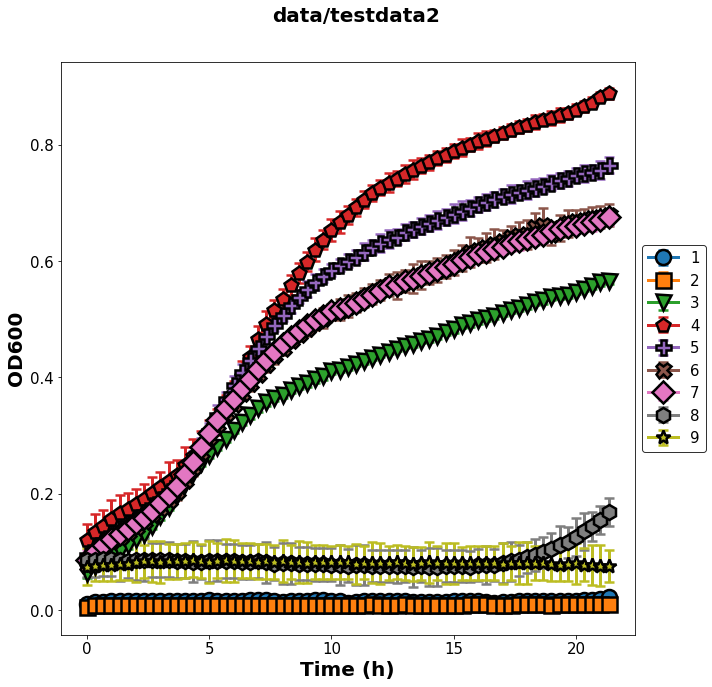

In [15]:
myxl = WellPlate(data = file, setup = plate)
myxl.create96Wellplate()
myxl.enumerateSamples()
myxl.createReplicatesList()
myxl.setActiveSheet()
myxl.setStartExcelCell()
myxl.getNumTimepoints()
myxl.getAllDataTables()
myxl.concatAllReplicateTables()
myxl.summarizeAllTimepoints()
myxl.subtractBackgroundFromAll()
myxl.formatFinalOutput()
#myxl.saveFinalOutput()
myxl.graph()

In [14]:
myxl.final

,Time,Mean,StDev,SEM,Group
0,0.000,0.1215,0.0930,0.0268,4
1,0.333,0.1337,0.0910,0.0322,4
2,0.667,0.1454,0.0913,0.0264,4
3,1.000,0.1575,0.0906,0.0320,4
4,1.333,0.1669,0.0903,0.0319,4
...,...,...,...,...,...
580,20.000,0.0100,0.0169,0.0060,2
581,20.333,0.0099,0.0173,0.0050,2
582,20.667,0.0102,0.0176,0.0051,2
583,21.000,0.0100,0.0176,0.0051,2


In [12]:
myxl.plate_setup

,1,2,3,4,5,6,7,8,9,10,11,12
row,,,,,,,,,,,,
A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B,NaN,1,1,1,NaN,2,2,2,NaN,NaN,NaN,NaN
C,NaN,3,3,3,NaN,Blank,Blank,Blank,NaN,NaN,NaN,NaN
D,NaN,4,4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E,NaN,5,5,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F,NaN,6,6,7,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
G,NaN,8,8,9,9,9,NaN,NaN,NaN,NaN,NaN,NaN
H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
myxl.data = list(myxl.sheet.values)
myxl.start_row = 60
myxl.end_row = 68
def getWellTable(start_row, end_row):
    '''
    Get column names for each data table. This function will exit if the 
    well name is not in the list of well coordinates that contain samples.
    '''
    cols = [
        cell.value 
        for row in myxl.sheet.iter_rows(min_row=start_row,max_row=start_row)
        for cell in row
    ]

    if cols[0] not in myxl.cells:
        return
    else:
        '''
        Subset the cell values to only contain the data between the start_row and 
        end_row variables. This will only grab the data tables for each well.
        '''
        data = [myxl.data[row] for row in range(start_row,end_row)]

        df = pd.DataFrame(data, columns=cols)

        '''
        Drop any columns containing NA values. This usually happens when you plan the
        kinetic cycle to go for x amount of time, but stop it early.
        '''
        df.dropna(inplace=True, axis=1)

        '''
        Set name to be the sample name.
        '''
        locator = [
            True if cols[0] in s
            else False
            for s in myxl.replicates.values()
        ]
        idx = locator.index(True)
        df.name = list(myxl.replicates.keys())[idx]


        '''
        The first column only has metadata, so set that to the dataframe index.
        '''
        df.set_index(cols[0], inplace=True)

        time_min = [t/60 for t in df.iloc[0,:]]
        time_hr = [round(t/3600, 3) for t in df.iloc[0,:]]

        df.loc["Time [m]"] = time_min
        df.loc["Time [h]"] = time_hr
        df.sort_index(ascending = False, inplace=True)

    return df

In [ ]:
myxl.data[235:244]

In [ ]:
myxl.start_row = 60
myxl.end_row = 68
mylist = []
for i in range(96):
    print(i, myxl.start_row, myxl.end_row)
    mylist.append(getWellTable(myxl.start_row, myxl.end_row))
    # 2 blank spaces in between data tables
    myxl.start_row = myxl.end_row + 3
    myxl.end_row = myxl.start_row + 4 + 4

In [ ]:
pd.DataFrame(myxl.data).iloc[myxl.start_row-1:myxl.end_row,0:10]

In [ ]:
#c=[cell.value for row in myxl.sheet.iter_rows(min_row=60,max_row=60) for cell in row]
d = [myxl.data[r] for r in range(myxl.start_row, myxl.end_row)]
pd.DataFrame(d)

In [ ]:


self.data = list(self.sheet.values)
        
        def getWellTable(start_row, end_row):
            '''
            Get column names for each data table. This function will exit if the 
            well name is not in the list of well coordinates that contain samples.
            '''
            cols = [
                cell.value 
                for row in self.sheet.iter_rows(min_row=start_row,max_row=start_row)
                for cell in row
            ]
            
            if cols[0] not in self.cells:
                return None
            else:
                '''
                Subset the cell values to only contain the data between the start_row and 
                end_row variables. This will only grab the data tables for each well.
                '''
                data = [self.data[row] for row in range(start_row,end_row)]

                df = pd.DataFrame(data, columns=cols)

                '''
                Drop any columns containing NA values. This usually happens when you plan the
                kinetic cycle to go for x amount of time, but stop it early.
                '''
                df.dropna(inplace=True, axis=1)
                
                '''
                Set name to be the sample name.
                '''
                locator = [
                    True if cols[0] in s
                    else False
                    for s in self.replicates.values()
                ]
                idx = locator.index(True)
                df.name = list(self.replicates.keys())[idx]
                
                
                '''
                The first column only has metadata, so set that to the dataframe index.
                '''
                df.set_index(cols[0], inplace=True)

                time_min = [t/60 for t in df.iloc[0,:]]
                time_hr = [round(t/3600, 3) for t in df.iloc[0,:]]

                df.loc["Time [m]"] = time_min
                df.loc["Time [h]"] = time_hr
                df.sort_index(ascending = False, inplace=True)
            
            return df
        '''
        This will only return the data tables of wells with data. More specifically, it 
        will only return tables whose sample name is in the plate_setup file. This means 
        that you can have the code will ignore any blank cells, even if the plate reader 
        scanned those. Suppose that you had two separate experiments on the same plate. 
        You can keep the analysis separate by changing your plate_setup file. Or if
        there are wells you just want to ignore, leave the plate_setup file blank there.
        '''
        self.all_datatables = []
        for i in range(96):
            self.all_datatables.append(getWellTable(self.start_row, self.end_row))
            # 2 blank spaces in between data tables
            self.start_row = self.end_row + 3
            self.end_row = self.start_row + 4 + self.ppw
        '''
        Remove None values that are returned if the current data table is not in the replicates
        list.
        '''
        self.all_datatables = [df for df in self.all_datatables if type(df) == pd.DataFrame]
        
        '''
        Create time objects
        '''
        self.time_s = list(self.all_datatables[0].loc["Time [s]"])
        self.time_min = list(self.all_datatables[0].loc["Time [m]"])
        self.time_hr = list(self.all_datatables[0].loc["Time [h]"])

In [ ]:
#!/usr/bin/env python3
# coding: utf-8
def main():
    ###############
    ## Arguments ##
    ###############
    parser = argparse.ArgumentParser()
    parser.add_argument("-i", "--input", type=str, action="store", help="Input file", required=True)
    parser.add_argument("-p", "--plate", type=str, action="store", help="Plate setup file", required=True)
    parser.add_argument("-a", "--active", type=int, action="store", help="Active data sheet", default=0)
    parser.add_argument("-gs", "--graphsoft", type=str, action="store", help="Set graphing program: R, excel", default="R")
    parser.add_argument("-pp", "--produceplot", action="store_false", help="Autogenerate python plot: True/False")
    parser.add_argument("-y", "--yaxis", type=str, action="store", help="y-axis label on plot", default="OD600")
    parser.add_argument("-gm", "--graphmeth", type=str, action="store", help="graphing method: time series, time diff", default="time series")
    parser.add_argument("-pw", "--pointsperwell", type=int, action="store", help="readings per well", default=4)
    parser.add_argument("-ts", "--timescale", type=str, action="store", help="Time scale for data output and plotting", default="hr")
    args = parser.parse_args()

    file = args.input
    plate_setup_file = args.plate
    active_sheet = args.active
    graph_soft = args.graphsoft
    produce_plot = args.produceplot
    y_ax_label = args.yaxis
    graph_method = args.graphmeth
    points_per_well = args.pointsperwell
    time_scale = args.timescale

    print("\ndata file:", file)
    print("plate setup:", plate_setup_file)
    print("active sheet:", active_sheet + 1)
    print("graphing software:", graph_soft)
    print("y axis label:", y_ax_label)
    print("graphing method:", graph_method)
    print("points per well:", points_per_well)
    print("producing python plot:", produce_plot)
    print("time scale:", time_scale, "\n")
    
    ##################
    ## Process Data ##
    ##################
    data = WellPlate(data = file, setup = plate_setup_file, points_per_well=points_per_well)
    data.create96Wellplate()
    data.enumerateSamples()
    data.createReplicatesList()
    data.setActiveSheet(active_sheet)
    data.setStartExcelCell()
    data.getNumTimepoints()
    data.getAllDataTables()
    data.concatAllReplicateTables()
    data.summarizeAllTimepoints()
    data.subtractBackgroundFromAll()
    
    #################
    ## Format Data ##
    #################
    data.formatFinalOutput(graph_soft=graph_soft, time_scale=time_scale)
    data.saveFinalOutput()
    if produce_plot:
        data.graph(graph_method=graph_method)

if __name__ == "__main__":
   main()

In [ ]:
eval("2 x 2".replace("x", "*"))